## Business Problem

Country radio is the most popular radio format in the U.S., with more than 2,100 stations across the country. The radio success of a single can have a major impact on a country artist’s overall success.

As a Sony Nashville executive told [The Tennessean](https://www.tennessean.com/story/money/industries/music/2015/02/20/sony-nashville-ceo-talks-importance-country-radio/23768711/) in 2015, "If you aren't on country radio, you don't exist. . . I can't think of one star, much less superstar in country music, who wasn't broken by country radio. It's just a fact. That's where the active audience is. That's where they go to listen to it. "

For a country artist, radio play is a make-or-break prospect. Being able to predict the success of a song on country radio would allow artists and their teams to choose songs with the best chances of success as singles, as well as be able to adjust their overall plans due to their understanding of what radio play they can expect.

This project will analyze a number of features of country songs, with a goal of creating a model that will be able to predict the success of a single on the Billboard Country Airplay chart.

## Data Sources

The data for this project comes from three sources:

1. Billboard Country Airplay Chart data - five years worth of data.
2. Spotify API - audio features data
3. Manually coded gender and group versus solo artist

## Packages

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
pip install billboard.py

Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install spotipy

Note: you may need to restart the kernel to use updated packages.


In [51]:
from credentials import *

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import spotipy
import billboard
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

## Data Import

In [54]:
# Import Country Airplay chart from the week of September 28, 2019

chart = billboard.ChartData('country-airplay', date='2019-09-28')

In [55]:
#View first 5 chart entries

chart.entries[0:5]

[billboard.ChartEntry(title='Living', artist='Dierks Bentley'),
 billboard.ChartEntry(title="I Don't Know About You", artist='Chris Lane'),
 billboard.ChartEntry(title="Knockin' Boots", artist='Luke Bryan'),
 billboard.ChartEntry(title='Southbound', artist='Carrie Underwood'),
 billboard.ChartEntry(title="The Ones That Didn't Make It Back Home", artist='Justin Moore')]

In [56]:
# Create new dataframe for Billboard Chart Data

chart_df = pd.DataFrame(columns=['song_title','artist','rank','date'])
max_allowed = 312
attempt = 0

while chart.previousDate:
    attempt +=1
    #Stops running after 5 years worth of data
    if attempt < max_allowed:
        for i in range(0,60):
            df = pd.DataFrame({'song_title':[chart[i].title], 'artist':[chart[i].artist], 'rank':[chart[i].rank], 'date':[chart.date]})
            chart_df = chart_df.append(df, ignore_index=True)
        #Sets chart date to previous week so it can pull in that week's data next
        chart=billboard.ChartData('country-airplay', chart.previousDate)
        #Sets a 5 second break between loops to prevent an error due to too many rapid requests
        time.sleep(5)
    else:
        break
    

In [57]:
chart_df.head()

,song_title,artist,rank,date
0,Living,Dierks Bentley,1,2019-09-28
1,I Don't Know About You,Chris Lane,2,2019-09-28
2,Knockin' Boots,Luke Bryan,3,2019-09-28
3,Southbound,Carrie Underwood,4,2019-09-28
4,The Ones That Didn't Make It Back Home,Justin Moore,5,2019-09-28


In [58]:
# Summary statistics

chart_df.describe()

,song_title,artist,rank,date
count,18660,18660,18660,18660
unique,869,295,60,311
top,Every Little Thing,Thomas Rhett,60,2014-11-29
freq,78,296,311,60


In [59]:
# Drop duplicates, keeping only the highest ranking week for each song

chart_df = chart_df.sort_values(by='rank', ascending=True).drop_duplicates(subset='song_title')

In [60]:
# Reset index after dropping rows
chart_df.reset_index(drop=True, inplace=True)

In [61]:
# Clean artist names to allow songs to match with Spotify data

for i in range(len(chart_df)-1):
    if 'Featuring' in chart_df.artist[i]:
        chart_df.artist[i]=chart_df.artist[i].split("Featuring", maxsplit=1)[0]
    if 'With' in chart_df.artist[i]:
        chart_df.artist[i]=chart_df.artist[i].split("With", maxsplit=1)[0]
    if 'Duet' in chart_df.artist[i]:
        chart_df.artist[i]=chart_df.artist[i].split("Duet", maxsplit=1)[0]
    if ',' in chart_df.artist[i]:
        chart_df.artist[i]=chart_df.artist[i].split(",", maxsplit=1)[0]
    if '+' in chart_df.artist[i]:
        chart_df.artist[i]=chart_df.artist[i].split(",", maxsplit=1)[0]
    if  chart_df.artist[i]=='David Lee Murphy & Kenny Chesney':
        chart_df.artist[i]='David Lee Murphy'
    if  chart_df.artist[i]=='Tim McGraw & Faith Hill':
        chart_df.artist[i]='Tim McGraw'
    if  chart_df.artist[i]=='Jerrod Niemann & Lee Brice':
        chart_df.artist[i]='Jerrod Niemann'
    if  chart_df.artist[i]=='Reba McEntire & Lauren Daigle':
        chart_df.artist[i]='Reba McEntire'
    if  chart_df.artist[i]=='Bebe Rexha & Florida Georgia Line':
        chart_df.artist[i]='Bebe Rexha'
    if  chart_df.artist[i]=='Garth Brooks & Blake Shelton':
        chart_df.artist[i]='Garth Brooks'
    if  chart_df.artist[i]=='Willie Robertson & Luke Bryan':
        chart_df.artist[i]='Willie Robertson'

In [62]:
# Remove songs not on Spotify

chart_df = chart_df[chart_df.artist != 'Garth Brooks']
chart_df = chart_df[chart_df.artist != 'Tucker Beathard']
chart_df = chart_df[chart_df.artist != 'Candi Carpenter']
chart_df = chart_df[chart_df.song_title != 'A Few More Cowboys']
chart_df = chart_df[chart_df.song_title != 'PrizeFighter']
chart_df = chart_df[chart_df.song_title != 'Just Another Love Song']
chart_df = chart_df[chart_df.song_title != 'One Night Between Friends']
chart_df = chart_df[chart_df.song_title != 'Santa Baby']

In [63]:
# Reset index after dropping rows
chart_df.reset_index(drop=True, inplace=True)

In [64]:
# Create five blank lists
# Then append to them using the results from the Spotify search of the songs in the Billboard chart dataframe
# Create a none counter to identify every time the search fails to return any results

artist_name=[]
track_name=[]
track_id=[]
popularity=[]
rank=[]
None_counter=0

for i in range(len(chart_df)-1):
    track_results = sp.search(q=('artist:' + chart_df.artist[i] + ' track: ' + chart_df.song_title[i]), limit=1, type='track')
    if track_results['tracks']['items']!=[]:
        rank.append(chart_df['rank'][i])
        for i, t in enumerate(track_results['tracks']['items']):
            if t == None:
                None_counter = None_counter + 1
            else:
                artist_name.append(t['artists'][0]['name'])
                track_name.append(t['name'])
                track_id.append(t['id'])
                popularity.append(t['popularity'])

In [65]:
# Create a dataframe from the five lists

spotify_df = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity,'rank':rank})
print(spotify_df.shape)
spotify_df.head()

(812, 5)


,artist_name,track_name,track_id,popularity,rank
0,Dierks Bentley,Living,54K7AZoGpQklpygKrxZlKN,76,1
1,Luke Bryan,"Sunrise, Sunburn, Sunset",53yTYusPQJ1AApL1hi0Dnc,70,1
2,Jason Aldean,Burnin' It Down,5HJqpDspKDKwQpLjvkcIsD,66,1
3,Sam Hunt,Leave The Night On,3wx2kQWPn9p5UppQbNhPAk,67,1
4,Thomas Rhett,Life Changes,4Vxu50qVrQcycjRyJQaZLC,71,1


In [66]:
# Create an empty dataframe, then fill with audio features accessed from the Spotify API

audio_features_df = pd.DataFrame(columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'])

for i in range(len(spotify_df)-1):
    audio_features_df = audio_features_df.append(sp.audio_features(tracks=[spotify_df.track_id[i]]))

In [67]:
# Merge audio features dataframe with basic Spotify dataframe

track_df = audio_features_df.merge(spotify_df, left_on='id', right_on='track_id')

In [68]:
column_order = ['track_id',
'artist_name',
'track_name',
'rank',
'danceability',
'energy',
'key',
'loudness',
'mode',
'speechiness',
'acousticness',
'instrumentalness',
'liveness',
'valence',
'tempo',
'duration_ms',
'time_signature']

In [69]:
# Reorder columns

track_df = track_df.reindex(columns=column_order)

In [70]:
# Manually create a list of duos/groups

groups=['Maddie & Tae',
 'Old Dominion',
 'Florida Georgia Line',
 'Lady Antebellum',
 'Zac Brown Band',
 'Dan + Shay',
 'Eli Young Band',
 'Parmalee',
 'Rascal Flatts',
 'Little Big Town',
 'LANCO',
 'A Thousand Horses',
 'LOCASH',
 'Brothers Osborne',
 'Midland',
 'Thompson Square',
 'High Valley',
 'Big & Rich',
 'Runaway June',
 'The Band Perry',
 'The Swon Brothers',
 'Sugarland',
 'Gloriana',
 'Artists Of Then, Now & Forever',
 'The Cadillac Three',
 'Love and Theft',
 'The Henningsens',
 'Josh Abbott Band',
 'Montgomery Gentry',
 'Brooks & Dunn',
 'Gone West',
 'American Young',
 "Chasin' Crazy",
 'The Railers',
 'James Barker Band',
 'Radio Romance',
 'The Last Bandoleros',
 'King Calaway',
 'Waterloo Revival',
 'Pistol Annies',
 'Breaking Southwest',
 'Sir Rosevelt',
 'Everette',
 'Blackjack Billy',
 'Sister C',
 'Bobby Bones & The Raging Idiots']

In [71]:
# Manually create a list of artist that are female (solo or group) and mixed gender groups.

female=['Maddie & Tae', 
 'Bebe Rexha', 
 'Maren Morris', 
 'Lauren Alaina', 
 'Kelsea Ballerini', 
 'Carrie Underwood', 
 'Carly Pearce', 
 'Cam', 
 'Miranda Lambert', 
 'Jana Kramer', 
 'Taylor Swift', 
 'Cassadee Pope', 
 'Danielle Bradberry', 
 'RaeLynn',
 'Sara Evans',
 'Lindsay Ell',
 'Trisha Yearwood',
 'Jennifer Nettles',
 'Ingrid Andress',
 'Sheryl Crow',
 'Reba McEntire'
 'Ashley McBryde',
 'Kacey Musgraves',
 'Mickey Guyton',
 'Shania Twain',
 'Leah Turner',
 'Brandy Clark',
 'Caylee Hammack',
 'Natalie Stovall',
 'Clare Dunn',
 'Maggie Rose',
 'Martina McBride',
 'Lucy Hale',
 'Brooke Eden',
 'Kelleigh Bannen',
 'Kellie Pickler',
 'Kelly Clarkson',
 'Pistol Annies',
 'Lucy Angel',
 'P!nk',
 'Ashley Monroe',
 'Jillian Jacqueline',
 'Gabby Barrett',
 'Caroline Jones',
 'Rachel Wammack',
 'Jamie Lynn Spears',
 'Ashley Campbell',
 'Stephanie Quayle',
 'Shakira',
 'Kristy Lee Cook',
 'Abby Anderson',
 'LeAnn Rimes',
 'Bailey Bryan',
 'Sister C',
 'Tara Thompson',
 'Runaway June']

mixed=['Lady Antebellum',
 'Little Big Town',
 'Thompson Square',
 'The Band Perry',
 'Sugarland',
 'Gloriana',
 'The Henningsens',
 'Gone West',
 'American Young',
 'The Railers',
 'Breaking Southwest',
 'Artists Of Then, Now & Forever']

In [72]:
# Create an is_group column using the list created above

track_df['is_group']=np.nan

for i in range(len(track_df)):
    if track_df['artist_name'][i] in groups:
        track_df['is_group'][i]=1
    else:
        track_df['is_group'][i]=0   

In [73]:
# Create a gender column using the lists created above

track_df['gender']=np.nan

for i in range(len(track_df)):
    if track_df['artist_name'][i] in female:
        track_df['gender'][i]='female'
    elif track_df['artist_name'][i] in mixed:
        track_df['gender'][i]='mixed'
    else:
        track_df['gender'][i]='male'

In [74]:
track_df.describe(include='all')

,track_id,artist_name,track_name,rank,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_group,gender
count,811,811,811,811.000000,811.000000,811.000000,811.0,811.000000,811.0,811.000000,811.000000,811.0,811.000000,811.000000,811.000000,811.0,811.0,811.000000,811
unique,811,224,811,NaN,NaN,NaN,12.0,NaN,2.0,NaN,NaN,285.0,NaN,NaN,NaN,784.0,4.0,NaN,3
top,6mBlft6IhCJwPNKhnbb0wK,Jason Aldean,Caught Up In The Country,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,190587.0,4.0,NaN,male
freq,1,17,1,NaN,NaN,NaN,99.0,NaN,718.0,NaN,NaN,502.0,NaN,NaN,NaN,3.0,773.0,NaN,645
mean,NaN,NaN,NaN,23.933416,0.568727,0.736852,NaN,-5.443938,NaN,0.047960,0.169849,NaN,0.171069,0.557468,125.079513,NaN,NaN,0.196054,NaN
std,NaN,NaN,NaN,21.053031,0.093981,0.156695,NaN,1.852772,NaN,0.060613,0.201140,NaN,0.114718,0.204050,31.541528,NaN,NaN,0.397255,NaN
min,NaN,NaN,NaN,1.000000,0.169000,0.062800,NaN,-17.077000,NaN,0.023000,0.000226,NaN,0.021200,0.067300,48.718000,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,2.000000,0.510500,0.657500,NaN,-6.307500,NaN,0.030600,0.027150,NaN,0.097450,0.405000,97.999000,NaN,NaN,0.000000,NaN
50%,NaN,NaN,NaN,20.000000,0.573000,0.777000,NaN,-5.229000,NaN,0.036600,0.088300,NaN,0.122000,0.560000,122.981000,NaN,NaN,0.000000,NaN
75%,NaN,NaN,NaN,45.000000,0.632000,0.856000,NaN,-4.251500,NaN,0.047850,0.252000,NaN,0.220000,0.717000,150.111500,NaN,NaN,0.000000,NaN


In [75]:
# Save resulting dataframe to CSV

track_df.to_csv('./track_df.csv')

## Exploratory Data Analysis

In [76]:
track_df.dtypes

track_id             object
artist_name          object
track_name           object
rank                  int64
danceability        float64
energy              float64
key                  object
loudness            float64
mode                 object
speechiness         float64
acousticness        float64
instrumentalness     object
liveness            float64
valence             float64
tempo               float64
duration_ms          object
time_signature       object
is_group            float64
gender               object
dtype: object

In [77]:
# Convert is_group to integer

track_df.is_group = track_df.is_group.astype(int)

In [78]:
# Number of unique artists in the dataset

len(track_df.artist_name.unique())

224

In [79]:
# Key integers map to pitches using standard Pitch Class notation. There are no missing values
 
track_df.key.value_counts()

0     99
2     89
7     85
9     81
1     76
6     70
4     65
11    60
8     58
5     54
10    37
3     37
Name: key, dtype: int64

In [80]:
# Mode is a binomial variable indicating if a song is major or minor. This dataset is overwhelmingly major.

track_df['mode'].value_counts()

1    718
0     93
Name: mode, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


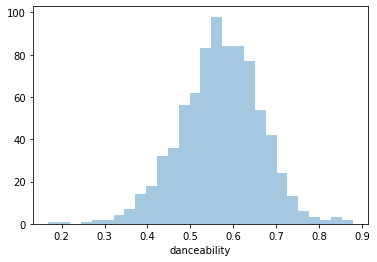

In [95]:
print(sns.distplot(track_df.danceability, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


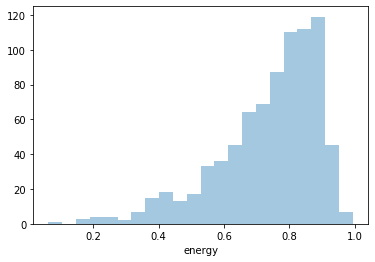

In [96]:
print(sns.distplot(track_df.energy, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


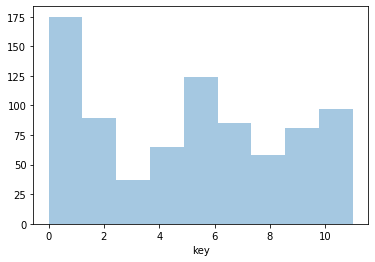

In [97]:
print(sns.distplot(track_df.key, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


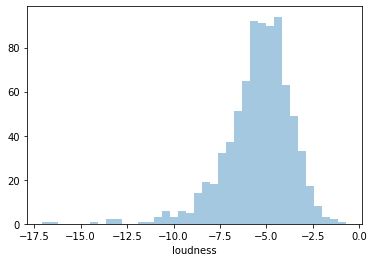

In [98]:
print(sns.distplot(track_df.loudness, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


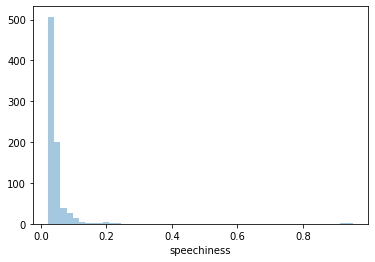

In [99]:
print(sns.distplot(track_df.speechiness, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


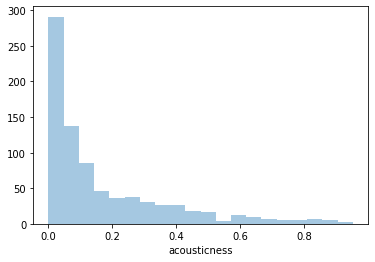

In [100]:
print(sns.distplot(track_df.acousticness, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


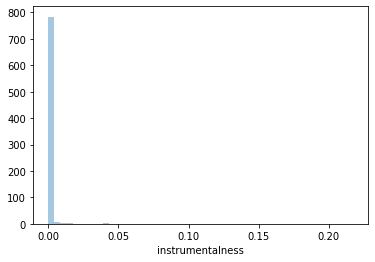

In [101]:
print(sns.distplot(track_df.instrumentalness, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


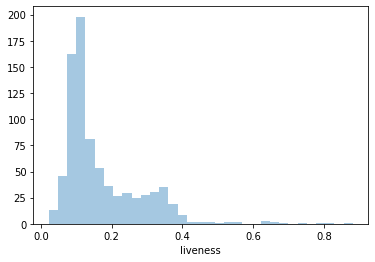

In [102]:
print(sns.distplot(track_df.liveness, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


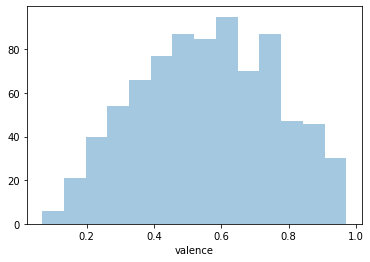

In [103]:
print(sns.distplot(track_df.valence, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


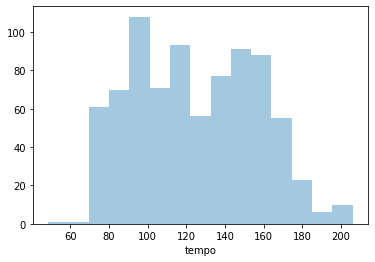

In [104]:
print(sns.distplot(track_df.tempo, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


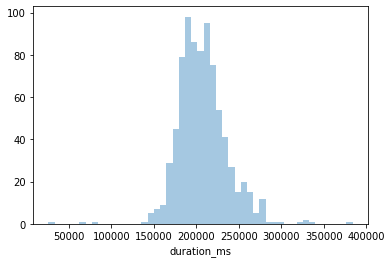

In [105]:
print(sns.distplot(track_df.duration_ms, kde=False))

AxesSubplot(0.125,0.125;0.775x0.755)


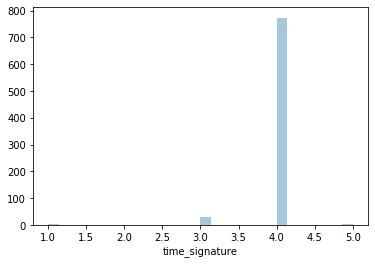

In [106]:
print(sns.distplot(track_df.time_signature, kde=False))

In [82]:
# Dummy out gender, which has 3 categories (male, female, mixed) - then drop the mixed column

track_df = pd.get_dummies(track_df, columns=['gender'])

track_df.drop('gender_mixed', axis=1, inplace = True)

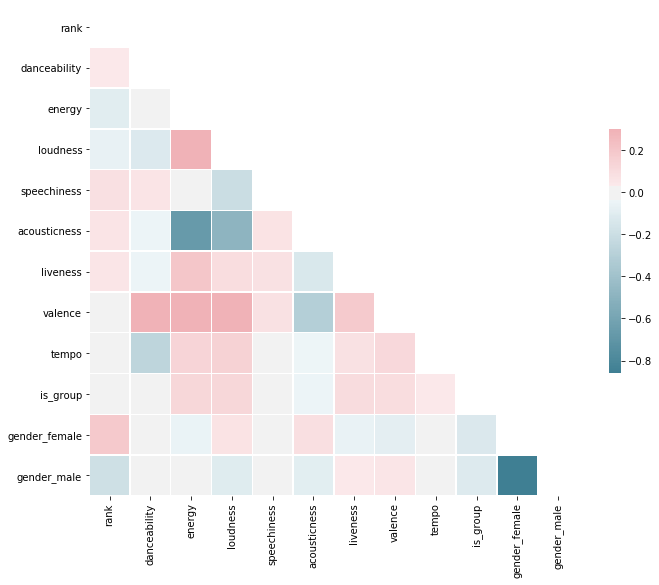

In [83]:
# Compute the correlation matrix
corr = track_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<Figure size 1440x720 with 0 Axes>

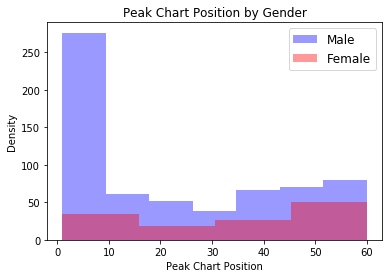

<Figure size 1440x720 with 0 Axes>

In [84]:
#Histogram of peak rank by gender

male_df =track_df[track_df.gender_male==1]
sns.distplot(male_df['rank'],  kde=False,label='Male', color='blue')

female_df = track_df[track_df.gender_female==1]
sns.distplot(female_df['rank'],  kde=False, label='Female', color='red')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Peak Chart Position by Gender')
plt.xlabel('Peak Chart Position')
plt.ylabel('Density')
plt.figure(figsize=(20,10))

In [85]:
print('Percent of male songs that hit number 1: ' + str(len(male_df[male_df['rank']==1])/len(male_df)))
print('Number of male songs that hit number 1: ' + str(len(male_df[male_df['rank']==1])))
print('Number of male songs that didnt hit number 1: ' + str(len(male_df[male_df['rank']!=1])))

Percent of male songs that hit number 1: 0.28527131782945736
Number of male songs that hit number 1: 184
Number of male songs that didnt hit number 1: 461


In [86]:
print('Percent of female songs that hit number 1: ' + str(len(female_df[female_df['rank']==1])/len(female_df)))
print('Number of female songs that hit number 1: ' + str(len(female_df[female_df['rank']==1])))
print('Number of female songs that didnt hit number 1: ' + str(len(female_df[female_df['rank']!=1])))

Percent of female songs that hit number 1: 0.09230769230769231
Number of female songs that hit number 1: 12
Number of female songs that didnt hit number 1: 118


In [87]:
print('Number of unique female artists to hit number 1: ' + str(len(female_df[female_df['rank']==1].artist_name.value_counts())))
print('Number of unique male artists to hit number 1: ' + str(len(male_df[male_df['rank']==1].artist_name.value_counts())))

Number of unique female artists to hit number 1: 7
Number of unique male artists to hit number 1: 53


In [88]:
group_df = track_df[track_df.is_group==1]
solo_df = track_df[track_df.is_group==0]

In [89]:
print('Percent of solo artist songs that hit number 1: ' + str(len(solo_df[solo_df['rank']==1])/len(solo_df)))
print('Number of solo artist songs that hit number 1: ' + str(len(solo_df[solo_df['rank']==1])))
print('Number of solo artist songs that didnt hit number 1: ' + str(len(solo_df[solo_df['rank']!=1])))

Percent of solo artist songs that hit number 1: 0.24846625766871167
Number of solo artist songs that hit number 1: 162
Number of solo artist songs that didnt hit number 1: 490


In [90]:
print('Percent of duo/group artist songs that hit number 1: ' + str(len(group_df[group_df['rank']==1])/len(group_df)))
print('Number of duo/group artist songs that hit number 1: ' + str(len(group_df[group_df['rank']==1])))
print('Number of duo/group artist songs that didnt hit number 1: ' + str(len(group_df[group_df['rank']!=1])))

Percent of duo/group artist songs that hit number 1: 0.23270440251572327
Number of duo/group artist songs that hit number 1: 37
Number of duo/group artist songs that didnt hit number 1: 122


In [91]:
print('Number of unique all male groups: ' +str(len(group_df[group_df.gender_male==1])))
print(len(group_df[group_df.gender_female==1]))

Number of unique all male groups: 112
11


In [92]:
male_group_df = group_df[group_df.gender_male==1]
female_group_df = group_df[group_df.gender_female==1]

In [93]:
print('Percent of male group songs that hit number 1: ' + str(len(male_group_df[male_group_df['rank']==1])/len(male_group_df)))
print('Number of male group songs that hit number 1: ' + str(len(male_group_df[male_group_df['rank']==1])))
print('Number of male group songs that didnt hit number 1: ' + str(len(male_group_df[male_group_df['rank']!=1])))
print('Percent of groups that are all male: ' + str(len(male_group_df)/len(group_df)))

Percent of male group songs that hit number 1: 0.29464285714285715
Number of male group songs that hit number 1: 33
Number of male group songs that didnt hit number 1: 79
Percent of groups that are all male: 0.7044025157232704


In [94]:
print('Percent of female group songs that hit number 1: ' + str(len(female_group_df[female_group_df['rank']==1])/len(female_group_df)))
print('Number of female group songs that hit number 1: ' + str(len(female_group_df[female_group_df['rank']==1])))
print('Number of female group songs that didnt hit number 1: ' + str(len(female_group_df[female_group_df['rank']!=1])))

Percent of female group songs that hit number 1: 0.09090909090909091
Number of female group songs that hit number 1: 1
Number of female group songs that didnt hit number 1: 10


## Modeling

In [174]:
feature_cols = ['danceability', 'energy', 'key', 'loudness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'is_group', 'gender_male']
X = track_df[feature_cols]
y = track_df['rank']

### Linear Regression

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=22)

In [176]:
# Scale data

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform (X_test)

In [177]:
# instantiate model
linreg = LinearRegression()

# fit model
linreg.fit(X_train_sc,y_train)

# store prediction
y_pred = linreg.predict(X_test_sc)

Text(0, 0.5, 'actual')

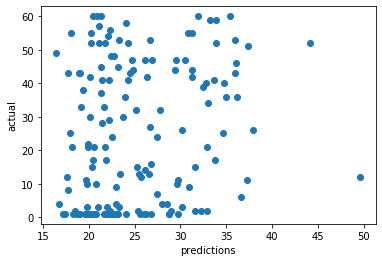

In [178]:
# Plot the predicted vs actual ranks

plt.scatter(y_pred, y_test)
plt.xlabel('predictions')
plt.ylabel('actual')

In [179]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 18.24283532680292
Mean Squared Error: 414.9281521188981
Root Mean Squared Error: 20.36978527424622


In [180]:
coeff_df = pd.DataFrame(linreg.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
danceability,1.005698
energy,-3.326936
key,-0.661779
loudness,0.512507
acousticness,-0.977386
instrumentalness,1.372038
liveness,1.256789
valence,-0.123320
tempo,0.040871
is_group,-0.708990


### Decision Tree

In [181]:
# evaluate a Decision Tree model

DT = DecisionTreeRegressor(max_depth=5,random_state=22)
DT = DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 19.039588895105446


In [182]:
pd.DataFrame(list(zip(feature_cols,treereg.feature_importances_)))

,0,1
0,danceability,0.179275
1,energy,0.077400
2,key,0.092123
3,loudness,0.032857
4,acousticness,0.071595
5,instrumentalness,0.000000
6,liveness,0.118797
7,valence,0.212753
8,tempo,0.027175
9,is_group,0.000000


### Random Forest

In [183]:
param_grid = {'bootstrap':[True],
              'max_depth': np.arange(1, 5),
              'min_samples_leaf': np.arange(1, 5),
              'max_features': np.arange(1, 5),
              'n_estimators': [100,200,300,1000],}

rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)

In [184]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True], 'max_depth

In [185]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 2,
 'min_samples_leaf': 4,
 'n_estimators': 100}

In [186]:
grid_search.score(X_test, y_test)

0.04347474195792855

In [187]:
grid_search.best_score_

0.01109905029802967

In [188]:
# Run model with best parameters
rf_model_optimal = RandomForestRegressor(max_depth=4, max_features=2, min_samples_leaf=1, n_estimators=200)

rf_model_optimal.fit(X_train, y_train)

y_pred = rf_model_optimal.predict(X_test)

print('MSE: ', mean_absolute_error(y_test, y_pred))

MSE:  18.317734347952207


Text(0, 0.5, 'actual')

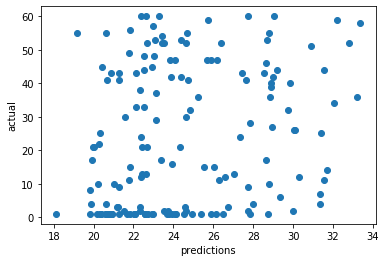

In [189]:
# Plot the predicted vs actual ranks

plt.scatter(y_pred, y_test)
plt.xlabel('predictions')
plt.ylabel('actual')

In [190]:
pd.DataFrame(list(zip(feature_cols,rf_model_optimal.feature_importances_)))

,0,1
0,danceability,0.105639
1,energy,0.130210
2,key,0.052034
3,loudness,0.098947
4,acousticness,0.095543
5,instrumentalness,0.068394
6,liveness,0.104745
7,valence,0.124479
8,tempo,0.099206
9,is_group,0.005834


## Bringing in a new song to predict

In [191]:
#Pull audio features for Homecoming Queen by Kelsea Ballerini

sp.audio_features(tracks=['spotify:track:1s71G3V7XQaVo5IOR6gLbp'])

[{'danceability': 0.462,
  'energy': 0.512,
  'key': 9,
  'loudness': -5.443,
  'mode': 1,
  'speechiness': 0.0334,
  'acousticness': 0.478,
  'instrumentalness': 0,
  'liveness': 0.0993,
  'valence': 0.29,
  'tempo': 114.014,
  'type': 'audio_features',
  'id': '1s71G3V7XQaVo5IOR6gLbp',
  'uri': 'spotify:track:1s71G3V7XQaVo5IOR6gLbp',
  'track_href': 'https://api.spotify.com/v1/tracks/1s71G3V7XQaVo5IOR6gLbp',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1s71G3V7XQaVo5IOR6gLbp',
  'duration_ms': 167796,
  'time_signature': 4}]

In [192]:
# Audio Features for Homecoming Queen by Kelsea Ballerini

danceability=.462
energy=.512
key=9
loudness=-5.443
acousticness=.478
instrumentalness=0
liveness=.0993
valence=.29
tempo=114.014
is_group=0
gender_male=0
gender_female=1

In [194]:
print(rf_model_optimal.predict(np.array([danceability, energy, key, loudness, acousticness, instrumentalness, liveness, valence, tempo, is_group, gender_male]).reshape(1,-1)))

[30.19720448]


In [195]:
#Pull audio features for I'll Be the Moon by Ryan Hurd

sp.audio_features(tracks=['spotify:track:0aqO107zsXsc7IQgTsUVhH'])

[{'danceability': 0.523,
  'energy': 0.699,
  'key': 4,
  'loudness': -7.952,
  'mode': 1,
  'speechiness': 0.032,
  'acousticness': 0.376,
  'instrumentalness': 9.01e-06,
  'liveness': 0.234,
  'valence': 0.198,
  'tempo': 83.014,
  'type': 'audio_features',
  'id': '0aqO107zsXsc7IQgTsUVhH',
  'uri': 'spotify:track:0aqO107zsXsc7IQgTsUVhH',
  'track_href': 'https://api.spotify.com/v1/tracks/0aqO107zsXsc7IQgTsUVhH',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0aqO107zsXsc7IQgTsUVhH',
  'duration_ms': 213108,
  'time_signature': 4}]

In [196]:
# Audio Features for I'll Be the Moon by Ryan Hurd

danceability=.523
energy=.699
key=4
loudness=-7.952
acousticness=.376
instrumentalness=9.01e-06
liveness=.234
valence=.198
tempo=83.014
is_group=0
gender_male=1
gender_female=0

In [197]:
print(rf_model_optimal.predict(np.array([danceability, energy, key, loudness, acousticness, instrumentalness, liveness, valence, tempo, is_group, gender_male]).reshape(1,-1)))

[24.70039803]


In [198]:
current_chart = billboard.ChartData('country-airplay')

In [199]:
current_chart[0]

billboard.ChartEntry(title='Prayed For You', artist='Matt Stell')

In [200]:
#Pull audio features for Prayed for You by Matt Stell

sp.audio_features(tracks=['spotify:track:1cmnChE57SpRJR2oFNcTpv'])

[{'danceability': 0.595,
  'energy': 0.698,
  'key': 9,
  'loudness': -5.836,
  'mode': 1,
  'speechiness': 0.0361,
  'acousticness': 0.0851,
  'instrumentalness': 0,
  'liveness': 0.106,
  'valence': 0.518,
  'tempo': 140.035,
  'type': 'audio_features',
  'id': '1cmnChE57SpRJR2oFNcTpv',
  'uri': 'spotify:track:1cmnChE57SpRJR2oFNcTpv',
  'track_href': 'https://api.spotify.com/v1/tracks/1cmnChE57SpRJR2oFNcTpv',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1cmnChE57SpRJR2oFNcTpv',
  'duration_ms': 210373,
  'time_signature': 4}]

In [201]:
# Audio Features for Prayed for You by Matt Stell

danceability=.595
energy=.698
key=9
loudness=-5.836
acousticness=.0851
instrumentalness=0
liveness=.106
valence=.518
tempo=140.035
is_group=0
gender_male=1
gender_female=0

In [202]:
print(rf_model_optimal.predict(np.array([danceability, energy, key, loudness, acousticness, instrumentalness, liveness, valence, tempo, is_group, gender_male]).reshape(1,-1)))

[21.18939892]
